In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/MNIST',one_hot=True)

D:\Program\Anaconda\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [2]:
print('- Number of images in the training set:\t\t{}'.format(len(mnist.train.labels)))
print('- Number of images in the test sets:\t\t{}'.format(len(mnist.test.labels)))
print('- Number of images in the validation set:\t\t{}'.format(len(mnist.validation.labels)))

- Number of images in the training set:		55000
- Number of images in the test sets:		10000
- Number of images in the validation set:		5000


In [3]:
mnist.test.cls_integer = np.argmax(mnist.test.labels,axis=1)

In [4]:
image_size = 28
image_size_flat = image_size*image_size
image_shape = (image_size,image_size)
num_channel = 1
num_classes = 10
filter_size_1 = 5
filters_1 = 16
filter_size_2 = 5
filters_2 = 36
fc_num_neurons = 128

In [5]:
def plot_imgs(imgs,cls_actual,cls_predicted=None):
    assert len(imgs) == len(cls_actual) == 9
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape(image_shape),cmap='binary')
    if cls_predicted is None:
        xlabel = 'True:{0}'.format(cls_actual[i])
    else:
        xlabel = 'True:{0},Pred:{1}'.format(cls_actual[i],cls_predicted[i])
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_xlabel(xlabel)
    plt.show()

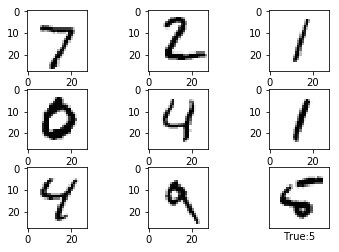

In [6]:
imgs = mnist.test.images[0:9]
cls_actual = mnist.test.cls_integer[0:9]
plot_imgs(imgs=imgs,cls_actual=cls_actual)

In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

def conv_layer(input,input_channels,filter_size,filters,use_pooling=True):
    shape = [filter_size,filter_size,input_channels,filters]
    filters_weights = new_weights(shape=shape)
    filters_biases = new_biases(length=filters)
    
    conv_layer = tf.nn.conv2d(input=input,
                              filter=filters_weights,
                              strides=[1, 1, 1, 1],
                              padding='SAME')
    conv_layer += filters_biases
    if use_pooling:
        pool_layer = tf.nn.max_pool(value=conv_layer,
                                    ksize=[1,2,2,1],
                                    strides=[1,2,2,1],
                                    padding='SAME')
    relu_layer = tf.nn.relu(pool_layer)
    return relu_layer,filters_weights

In [8]:
def flatten_layer(layer):
    shape = layer.get_shape()
    number_features = shape[1:4].num_elements()
    flatten_layer = tf.reshape(layer,[-1,number_features])
    return flatten_layer,number_features

In [9]:
def fc_layer(input,num_inputs,num_outputs,use_relu=True):
    fc_weights = new_weights(shape=[num_inputs,num_outputs])
    fc_biases = new_biases(length=num_outputs)
    fc_layer = tf.matmul(input,fc_weights) + fc_biases
    if use_relu:
        relu_layer = tf.nn.relu(fc_layer)
        return relu_layer
    return fc_layer

In [10]:
input_values = tf.placeholder(tf.float32,shape=[None,image_size_flat])
input_image = tf.reshape(input_values,[-1,image_size,image_size,num_channel])
y_actual = tf.placeholder(tf.float32,shape=[None,num_classes],name='y_actual')
y_actual_cls_integer = tf.argmax(y_actual,axis=1)
conv_layer_1,conv1_weights = conv_layer(input=input_image,
                                        input_channels=num_channel,
                                        filter_size = filter_size_1,
                                        filters=filters_1,
                                        use_pooling=True)


In [11]:
conv_layer_1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [12]:
conv_layer_2,conv2_weights = conv_layer(input =conv_layer_1,
                                        input_channels=filters_1,
                                        filter_size=filter_size_2,
                                        filters = filters_2,
                                        use_pooling=True)

In [13]:
conv_layer_2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [14]:
flatten_layer,number_features = flatten_layer(conv_layer_2)

In [15]:
flatten_layer

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [16]:
fc_layer_1 = fc_layer(input = flatten_layer,
                      num_inputs = number_features,
                      num_outputs=fc_num_neurons,
                      use_relu =True)

In [17]:
fc_layer_1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [18]:
fc_layer_2 = fc_layer(input=fc_layer_1,
                      num_inputs = fc_num_neurons,
                      num_outputs=num_classes,
                      use_relu = False)

In [19]:
fc_layer_2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [20]:
y_predicted = tf.nn.softmax(fc_layer_2)

In [21]:
y_predicted_cls_integer = tf.argmax(y_predicted,axis =1)

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_layer_2,
                                                        labels=y_actual)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [23]:
model_cost = tf.reduce_mean(cross_entropy)

In [24]:
model_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(model_cost)

In [25]:
model_correct_prediction = tf.equal(y_predicted_cls_integer,y_actual_cls_integer)

In [26]:
model_accuracy = tf.reduce_mean(tf.cast(model_correct_prediction,tf.float32))

In [27]:
session = tf.Session()

In [28]:
session.run(tf.global_variables_initializer())

In [29]:
train_batch_size = 64

In [30]:
total_iterations = 0

In [31]:
def optimize(num_iterations):
    global total_iterations
    for i in range(total_iterations,total_iterations+num_iterations):
        input_batch,y_actual_batch = mnist.train.next_batch(train_batch_size)
        feed_dict = {input_values:input_batch,
                     y_actual : y_actual_batch}
        session.run(model_optimizer,feed_dict=feed_dict)
        if i%100 ==0:
            acc_training_set = session.run(model_accuracy,feed_dict=feed_dict)
            print('Iteration:{0:>6},Accuracy Over the training set:{1:>6.1%}'.\
                  format(i + 1,acc_training_set))
    total_iterations += num_iterations

In [32]:
def plot_errors(cls_predicted,correct):
    incorrect = (correct==False)
    images = mnist.test.images[incorrect]
    cls_pred = cls_predicted[incorrect]
    cls_true = mnist.test.cls_integer[incorrect]
    plot_imgs(imgs=imgs[0:9],
             cls_actual = cls_actual[0:9],
             cls_predicted = cls_predicted[0:9])

In [33]:
def plot_confusionMatrix(cls_predicted):
    cls_actual = mnist.test.cls_integer
    conf_matrix = confusion_matrix(y_true=cls_actual,
                                  y_pred=cls_predicted)
    print(conf_matrix)
    plt.matshow(conf_matrix)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show()

In [34]:
test_batch_size = 256

In [35]:
def test_accuracy(show_errors = False,show_confusionMatrix=False):
    number_test = len(mnist.test.images)
    cls_predicted = np.zeros(shape=number_test,dtype=np.int)
    i = 0
    while i < number_test:
        j = min(i + test_batch_size,number_test)
        input_images = mnist.test.images[i:j,:]
        actual_labels = mnist.test.labels[i:j,:]
        feed_dict = {input_values:input_images,
                    y_actual:actual_labels}
        cls_predicted[i:j] = session.run(y_predicted_cls_integer,feed_dict=feed_dict)
        i = j
    cls_actual = mnist.test.cls_integer
    correct = (cls_actual ==cls_predicted)
    correct_number_images = correct.sum()
    testset_accuracy = float(correct_number_images)/number_test
    print('Accuracy on Test_Set:{0:1%} ({1}/{2})'.format(testset_accuracy,correct_number_images,number_test))
    if show_errors:
        print('Example errors:')
        plot_errors(cls_predicted=cls_predicted,correct=correct)
    if show_confusionMatrix:
        print('Confusion Matrix:')
        plot_confusionMatrix(cls_predicted=cls_predicted)

In [ ]:
test_accuracy()

Accuracy on Test_Set:10.180000% (1018/10000)


In [ ]:
optimize(num_iterations=9999)

Iteration:     1,Accuracy Over the training set:  6.2%
Iteration:   101,Accuracy Over the training set: 54.7%
Iteration:   201,Accuracy Over the training set: 85.9%
Iteration:   301,Accuracy Over the training set: 87.5%
Iteration:   401,Accuracy Over the training set: 82.8%
Iteration:   501,Accuracy Over the training set: 82.8%
Iteration:   601,Accuracy Over the training set: 92.2%
Iteration:   701,Accuracy Over the training set: 90.6%
Iteration:   801,Accuracy Over the training set: 90.6%
Iteration:   901,Accuracy Over the training set: 90.6%
Iteration:  1001,Accuracy Over the training set: 89.1%
Iteration:  1101,Accuracy Over the training set: 92.2%
Iteration:  1201,Accuracy Over the training set: 95.3%
Iteration:  1301,Accuracy Over the training set: 96.9%
Iteration:  1401,Accuracy Over the training set: 93.8%
Iteration:  1501,Accuracy Over the training set: 93.8%
Iteration:  1601,Accuracy Over the training set: 89.1%
Iteration:  1701,Accuracy Over the training set: 93.8%
Iteration:

In [ ]:
test_accuracy(show_errors=True,show_confusionMatrix=True)